# UHI analysis

We'll try to figure out whether there is a systematic relationship between elevated urban air temperatures and population density based on an archive of weather station data from [NOAA's GHCN](https://www.ncdc.noaa.gov/data-access/land-based-station-data/land-based-datasets/global-historical-climatology-network-ghcn) and population data from the [GHSL](https://ghsl.jrc.ec.europa.eu/). 


# ⚠ 

Some parts of this analysis take quite a while. Look for the fields mared with a 

# 🏁

these indicate where intermediate results have been stored and can simply be re-used instead of running the analysis again.

Import some libraries we'll use:


In [44]:
import urllib.request
import gzip
import zipfile
import pandas as pd
import os
from scipy import stats
import matplotlib.pyplot as plt
import rasterio as rio
import numpy as np
from pyproj import Proj, transform
from scipy.spatial import cKDTree  
from scipy import stats
import urllib.request

from sklearn import linear_model

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # larger plots

# Get NOAA weather stations

First, let's get the [list of NOAA weather stations](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt) so that we have a lat/lon location for each:

🏁

In [139]:
file = 'ghcnd-stations.txt'

if os.path.isfile(file):
    print('Stations already downloaded, using local file.')
else:
    print('Using online stations file directly.')
    file = 'https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt'

# we are using 100000 rows here to let pandas figure out the column widths - this is a bit slower, 
# but makes sure that we get all the stations way out west or south correctly without chopping of the minus sign 
stations = pd.read_fwf(file, 
            infer_nrows=100000, # how many rows to use to infer the column widths
            usecols = [0,1,2,3,5],
            names = ["station", "lat", "lon", "elevation", "name"])

stations.head()

Stations already downloaded, using local file.


,station,lat,lon,elevation,name
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL


Check the range of the lat and lon columns to make sure the coordinates have been parsed correctly:

In [140]:
print(f'Lats go from {stations.lat.min()} to {stations.lat.max()}')
print(f'Lons go from {stations.lon.min()} to {stations.lon.max()}')

Lats go from -90.0 to 83.65
Lons go from -179.983 to 179.32


Pull out the country ID from the station column (first two letters):

In [141]:
stations["country"] = stations["station"].astype(str).str[0:2]
stations.head()

,station,lat,lon,elevation,name,country
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE


Since the GHSL data we'll be using later is in Mollweide projection, we'll need to [project](https://github.com/pyproj4/pyproj) the lat/lon to the World Mollweide projection that the raster uses and pick up the values at those projected coordinates:

🏁

In [142]:
file = 'stations_moll.csv'

if os.path.isfile(file):
    print('Stations already projected to Mollweide, using local file.')
    stations = pd.read_csv(file, index_col=0)
else:
    inProj = Proj(init='epsg:4326')   # lat/lon 
    outProj = Proj('+proj=moll +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs', preserve_flags=True) # Mollweide

    projectedLocations = []

    # go through the list of stations and project each one to Mollweide
    for index, station in stations.iterrows():
        projectedLocations.append((transform(inProj,outProj,station['lon'],station['lat'])))

    # add the projected coordinates back to the stations dataframe
    stations['mollX'], stations['mollY'] = zip(*projectedLocations)  # 'unzip' with the *
    stations.to_csv(file)


stations.head()

Stations already projected to Mollweide, using local file.


,station,lat,lon,elevation,name,country,mollX,mollY
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06


# Spatial Index

Next, we'll build a spatial index of the stations, so we can quickly look up the nearest neighbors of any station. We'll be using the [scipy.spatial.cKDTree](https://docs.scipy.org/doc/scipy/reference/generated/scipy.spatial.cKDTree.query.html) (based on [this hint](https://gis.stackexchange.com/a/301935/33224).). For that, we'll pull out just the Mollweide coordinates and build the index based on those (otherwise SciPy will make a multidimensional index using all columns):

In [143]:
stationsIndex = cKDTree(stations[['mollX','mollY']].values)

Let's try to find the closest stations to a specific one by name:

In [144]:
def queryStation(stationID, stations, stationsIndex, k=1):
    queryCoords = stations[stations.station==stationID][['mollX','mollY']].values
    dd, ii = stationsIndex.query(queryCoords, 
                             k=range(2,2+k), # start at 2, otherwise we get the station itself as first result
                             n_jobs=-1,      # use all CPUs
                             p=2   )         # p-norm 2 = euclidian distance
    
    knn = stations.iloc[ii[0]]
    knn = knn.copy()  # otherwise we might be modifying the stations dataframe...
    knn['distance'] = dd[0]
    return knn

Test:

In [145]:
stationID = 'RQC00663871'   # GARZAS station
queryStation(stationID, stations, stationsIndex, k=5)

,station,lat,lon,elevation,name,country,mollX,mollY,distance
47206,RQC00660053,18.1614,-66.7222,506.0,ADJUNTAS 1 S,RQ,-6.479289e+06,2.231113e+06,1924.820868
47331,RQC00668684,18.1333,-66.7333,868.7,SALTILLO 2 ADJUNTAS,RQ,-6.481011e+06,2.227706e+06,2060.888936
47266,RQC00664614,18.1506,-66.7719,2.7,HUMACAO NATURAL RESERVE,RQ,-6.484363e+06,2.229804e+06,3735.475164
47207,RQC00660061,18.1747,-66.7978,557.8,ADJUNTAS SUBSTN,RQ,-6.486324e+06,2.232726e+06,6435.610695
47309,RQC00666982,18.0833,-66.7333,349.9,PENUELAS SALTO GARZAS,RQ,-6.482155e+06,2.221642e+06,8231.252200


# Get [GHSL population data](https://ghsl.jrc.ec.europa.eu/ghs_pop.php) for 1975

Download dir at http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/

🏁

In [146]:
file = 'GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.tif'

if os.path.isfile(file):
    print('GHSL population data for 1975 already downloaded.')
else:
    url = 'http://cidportal.jrc.ec.europa.eu/ftp/jrc-opendata/GHSL/GHS_POP_GPW4_GLOBE_R2015A/GHS_POP_GPW41975_GLOBE_R2015A_54009_250/V1-0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.zip'
    urllib.request.urlretrieve(url, file)
    
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('.')
    zip_ref.close()
    
    # remove the ZIP file and the extracted overview file - we don't need it and the .ovr file is huge (3GB!)
    os.remove('GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.zip')
    os.remove('GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.tif.ovr')

GHSL population data for 1975 already downloaded.


We'll use the data to assign each station an estimate of the population density in the GHSL cell that it is in. Since GHSL is in an equal area projection (i.e. all cells have the same area), we can safely do that.

We'll use [rasterio's sample method](https://gis.stackexchange.com/questions/190423/getting-pixel-values-at-single-point-using-rasterio) for that. Let's read in the GeoTIFF first:

In [147]:
pop1975 = rio.open(file)
pop1975

<open DatasetReader name='GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0/GHS_POP_GPW41975_GLOBE_R2015A_54009_250_v1_0.tif' mode='r'>

In [148]:
pop1975.bounds

BoundingBox(left=-17619594.54744353, bottom=-6484970.538131511, right=17877405.45255647, top=8750529.46186849)

In [149]:
pop1975.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 141988,
 'height': 60942,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["World_Mollweide",GEOGCS["GCS_WGS_1984",DATUM["D_WGS_1984",SPHEROID["WGS_1984",6378137.0,298.257223563]],PRIMEM["Greenwich",0.0],UNIT["Degree",0.017453292519943295]],PROJECTION["Mollweide"],PARAMETER["False_Easting",0.0],PARAMETER["False_Northing",0.0],PARAMETER["Central_Meridian",0.0],UNIT["Meter",1.0]]'),
 'transform': Affine(250.0, 0.0, -17619594.54744353,
        0.0, -250.0, 8750529.46186849)}

To get values at point locations, we can simply pass a list of ```(x,y)``` tuples and rasterio will return a list of values at those points:

In [150]:
for val in pop1975.sample([(8432553,2759349)]):
    print(val)

[2680.5662]


Check that all coordinates are in the raster's bounding box:

In [151]:
print(min(stations['mollX']) > pop1975.bounds.left)
print(max(stations['mollX']) < pop1975.bounds.right)

print(min(stations['mollY']) > pop1975.bounds.bottom)
print(max(stations['mollY']) < pop1975.bounds.top)

True
True
False
False


Okay, so there are some stations North and South of our raster. Remove the stations that are outside of our raster bounding box (they are not really useful for our UHI analysis anyway, and [rasterio seems trip over them](https://gis.stackexchange.com/questions/323481/error-using-rasterios-sample-method)):

In [152]:
print(f'Before removal: {len(stations.index)} stations.')
stations = stations.drop(stations[stations['mollY'] < pop1975.bounds.bottom].index)
stations = stations.drop(stations[stations['mollY'] > pop1975.bounds.top].index)
print(f'After removal: {len(stations.index)} stations.')

Before removal: 113951 stations.
After removal: 113848 stations.


Save to a CSV file again and re-build the spatial index, now that we have removed some stations:

In [153]:
stations.to_csv('stations_moll_inraster.csv')
stationsIndex = cKDTree(stations[['mollX','mollY']].values)

Now we can use those remaining station locations to sample the raster:

🏁

In [154]:
file = 'stations_moll_inraster_pop1975.csv'

if os.path.isfile(file):
    print('Stations data with 1975 population already generated; reusing existing file.')
    stations = pd.read_csv(file, index_col=0)
else:

    locations = list(zip(stations['mollX'], stations['mollY']))
    pop1975col = []

    for val in pop1975.sample(locations):
        pop1975col.append(val[0])

    # make this list a new column in our stations dataframe
    stations['pop1975'] = pop1975col
    stations.to_csv(file)

stations.head()

Stations data with 1975 population already generated; reusing existing file.


,station,lat,lon,elevation,name,country,mollX,mollY,pop1975
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,2.571450
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,21.834427


How many stations do we have in densely populated areas?

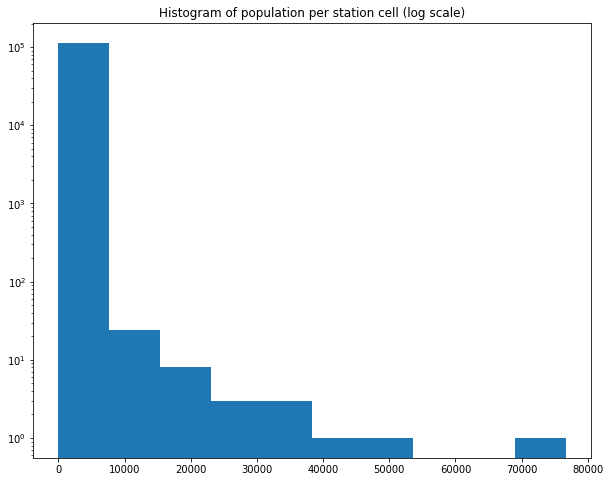

In [155]:
plt.hist(stations['pop1975'], log=True)
plt.title("Histogram of population per station cell (log scale)")
plt.show()

The cells in our population dataset are only [250x250m](https://ghsl.jrc.ec.europa.eu/ghs_pop2019.php), so to get population per km<sup>2</sup>, we actually have to multiply the number with 16 (just to make it a bit easier to compare to common measures of population density in people per km<sup>2</sup>:

In [156]:
stations['popdens1975'] = stations['pop1975'] * 16
stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY,pop1975,popdens1975
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,2.571450,41.143192
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,21.834427,349.350830


This list of ca. 150 of the most densely populated city *districts* globally has them all at more than 30k people per km<sup>2</sup>, how many do we have in that range?

In [157]:
print("Cells with more than 30k per sqkm: ", len(stations[stations['popdens1975'] > 30000]))
print("Cells with more than 20k per sqkm: ", len(stations[stations['popdens1975'] > 20000]))
print("Cells with more than 10k per sqkm: ", len(stations[stations['popdens1975'] > 10000]))

Cells with more than 30k per sqkm:  197
Cells with more than 20k per sqkm:  286
Cells with more than 10k per sqkm:  655


That's a small percentage, but it's what we've got, so let's roll with it.

Before we can take a look at the effect of population density on temperature, we need to get rid of the effect of elevation. We will calculate the difference in temperature (min and max) as well as the difference in elevation between each of the ca. 7 million observations in 1975 and the corresponding measurements at the nearest neighboring station (only looking at the rural stations, of course).

For that purpose, let's find the closest neighbor for each station first:

In [158]:
# add new columns to hold the ID of the nearest station and the distance to it

stations["NN"] = ""
stations["NN_dist"] = ""
stations["NN_elev"] = ""

stations.head()

,station,lat,lon,elevation,name,country,mollX,mollY,pop1975,popdens1975,NN,NN_dist,NN_elev
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000,,,
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000,,,
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000,,,
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,2.571450,41.143192,,,
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,21.834427,349.350830,,,


Iterate through the DF and fill these columns row by row. 

🔥 **TODO** This is reeeeally slow, I'm sure there must be a faster way to do this... for now, I'm at least making sure we only need to do this once by saving the results in a CSV that can just be loaded again

🏁

In [9]:
file = 'stations_with_nearest_neighbor.csv'

if os.path.isfile(file):
    print('Nearest neighbors already computed, using local file.')
    stations = pd.read_csv(file, index_col=0)
else:
    for index, row in stations.iterrows():
        s = row['station']
        
        nn = queryStation(s, stations, stationsIndex)
        
        nnstation = nn['station'].iloc[0]
        nndistance = nn['distance'].iloc[0]
        nnelev = nn['elevation'].iloc[0]
        
        stations.loc[stations.station == s, 'NN'] = nnstation
        stations.loc[stations.station == s, 'NN_dist'] = nndistance        
        stations.loc[stations.station == s, 'NN_elev'] = nnelev
        
    stations['nn_elev_diff'] = stations['elevation'] - stations['NN_elev']
        
    stations.to_csv(file)
        
stations.head()

Nearest neighbors already computed, using local file.


,station,lat,lon,elevation,name,country,mollX,mollY,pop1975,popdens1975,NN,NN_dist,NN_elev,nn_elev_diff
0,ACW00011604,17.1167,-61.7833,10.1,ST JOHNS COOLIDGE FLD,AC,-6.021233e+06,2.104299e+06,0.000000,0.000000,ACW00011647,2044.423916,19.2,-9.1
1,ACW00011647,17.1333,-61.7833,19.2,ST JOHNS,AC,-6.020901e+06,2.106316e+06,0.000000,0.000000,ACW00011604,2044.423916,10.1,9.1
2,AE000041196,25.3330,55.5170,34.0,SHARJAH INTER. AIRP,AE,5.226731e+06,3.092960e+06,0.000000,0.000000,AEM00041194,15427.585565,10.4,23.6
3,AEM00041194,25.2550,55.3640,10.4,DUBAI INTL,AE,5.214407e+06,3.083680e+06,2.571450,41.143192,AE000041196,15427.585565,34.0,-23.6
4,AEM00041217,24.4330,54.6510,26.8,ABU DHABI INTL,AE,5.168502e+06,2.985740e+06,21.834427,349.350830,AEM00041218,97173.049120,264.9,-238.1


While working with the data, I saw that some stations are missing elevation information (marked with `-999.9`), which we will be using later:

In [76]:
print(str(len(stations[stations.elevation == -999.9])),'out of',str(len(stations)),'lack elevation data.')

0 out of 113848 lack elevation data.


A small percentage, but let's still fix that. We'll use [GPS Visualizer's lookup service for that](https://www.gpsvisualizer.com/elevation). The API is not documented, but this was quite easy to figure out and saves us downloading gigabytes of data for the underlying [SRTM data](https://www2.jpl.nasa.gov/srtm/): 

In [74]:
def elevation_lookup(lat, lon):
    url = 'https://www.gpsvisualizer.com/elevation_data/elev2018.js?coords='+str(lat)+'%2C'+str(lon)+'&gv_nocache=1563196454722'

    with urllib.request.urlopen(url) as f:
        response = f.read(100).decode('utf-8')
        ele = response.split("(")[1].split(",")[0]
        if ele == 'null':
            return 0.0
        
        number = float(ele)
        if number == 0.0:
            return number
        
        return (1./number) # I don't know if this is some kind of super-cheap encryption they do to make it harder to use their API, but they do the same operation and the output make sense

    

Loop through the rows with missing stations and look up the elevation at that lat/lon position using our function. This is going to take a while for ~4000 stations without elevation 😴

🏁

In [2]:
file = 'stations_with_nearest_neighbor_fixed_elevation.csv'

if os.path.isfile(file):
    print('Elevation already looked up, using local file.')
    stations = pd.read_csv(file, index_col=0)
else:
    for index, row in stations[stations.elevation == -999.9].iterrows():
        new_elev = elevation_lookup(row.lat, row.lon)
        #print(new_elev)
        stations.loc[stations.station == row.station, 'elevation']  = new_elev
    
    # recalculate elevation difference
    stations['nn_elev_diff'] = stations['elevation'] - stations['NN_elev']
        
    stations.to_csv(file)
    print('Done looking up elevation values.')


Elevation already looked up, using local file.


Now we ca move on and ...

# Get the NOAA NCDC data

Download the data from NOAA. The columns in the file are documented [here](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/readme.txt).

In [3]:
file = '1975.csv.gz'
if os.path.isfile(file):
    print(file, 'already downloaded.')
else:
    urllib.request.urlretrieve('https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/by_year/1975.csv.gz', file)

1975.csv.gz already downloaded.


Before we can read the file, we'll define our own date parser:

In [4]:
noaadateparser = lambda x: pd.datetime.strptime(x, "%Y%m%d")


Unzip the file and load the CSV with pandas, using our date parser. We'll also give the columns names since the CSV doesn't have a header 🧟‍. This takes a few minutes:

In [5]:
with gzip.open('1975.csv.gz') as f:

    data_1975 = pd.read_csv(f, 
                            names = ["station", "date", "type", "value"],
                            usecols = [0,1,2,3],
                            parse_dates = ["date"],
                            date_parser = noaadateparser)

data_1975.head()

,station,date,type,value
0,CA008203164,1975-01-01,TMAX,17
1,CA008203164,1975-01-01,TMIN,-11
2,CA008203164,1975-01-01,PRCP,216
3,CA008203164,1975-01-01,SNOW,216
4,CA008105560,1975-01-01,TMAX,17


In [6]:
data_1975.dtypes

station            object
date       datetime64[ns]
type               object
value               int64
dtype: object

Only keep TMIN and TMAX:

In [7]:
data_1975 = data_1975[(data_1975["type"] == "TMAX") | (data_1975["type"] == "TMIN")] 
data_1975.head()

,station,date,type,value
0,CA008203164,1975-01-01,TMAX,17
1,CA008203164,1975-01-01,TMIN,-11
4,CA008105560,1975-01-01,TMAX,17
5,CA008105560,1975-01-01,TMIN,-67
10,CA007056600,1975-01-01,TMAX,-22


Join the stations to the temperature data:

In [8]:
data_1975 = pd.merge(data_1975, stations, on="station")
data_1975.head()

,station,date,type,value,lat,lon,elevation,name,country,mollX,mollY,pop1975,popdens1975,NN,NN_dist,NN_elev,nn_elev_diff
0,CA008203164,1975-01-01,TMAX,17,45.6,-60.75,15.0,LOWER L'ARDOISE,CA,-4.874275e+06,5.405209e+06,0.0,0.0,CA008200750,14316.80606,15.0,0.0
1,CA008203164,1975-01-01,TMIN,-11,45.6,-60.75,15.0,LOWER L'ARDOISE,CA,-4.874275e+06,5.405209e+06,0.0,0.0,CA008200750,14316.80606,15.0,0.0
2,CA008203164,1975-01-02,TMAX,-11,45.6,-60.75,15.0,LOWER L'ARDOISE,CA,-4.874275e+06,5.405209e+06,0.0,0.0,CA008200750,14316.80606,15.0,0.0
3,CA008203164,1975-01-02,TMIN,-72,45.6,-60.75,15.0,LOWER L'ARDOISE,CA,-4.874275e+06,5.405209e+06,0.0,0.0,CA008200750,14316.80606,15.0,0.0
4,CA008203164,1975-01-03,TMAX,-11,45.6,-60.75,15.0,LOWER L'ARDOISE,CA,-4.874275e+06,5.405209e+06,0.0,0.0,CA008200750,14316.80606,15.0,0.0


Next, we will prepare the data to **correct the temperature data for elevation**. First, we'll calculate the temperature difference to the nearest station in two steps:

1. get the temperature at the nearest neighbour (using a <a href="Self-join demo.ipynb" target="_blank">self-join</a> on the station ID / NN ID for a specific date and type)
2. add a new column with the difference

In [9]:
data_1975 = data_1975.merge(data_1975, left_on=['NN','date','type'], right_on=['station','date','type'])
data_1975.head()

,station_x,date,type,value_x,lat_x,lon_x,elevation_x,name_x,country_x,mollX_x,...,name_y,country_y,mollX_y,mollY_y,pop1975_y,popdens1975_y,NN_y,NN_dist_y,NN_elev_y,nn_elev_diff_y
0,CA007056600,1975-01-01,TMAX,-22,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,ST ELEUTHERE,CA,-5.438944e+06,5.607430e+06,0.0,0.0,CA007055104,9212.808188,657.0,-367.0
1,CA007056600,1975-01-01,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,ST ELEUTHERE,CA,-5.438944e+06,5.607430e+06,0.0,0.0,CA007055104,9212.808188,657.0,-367.0
2,CA007056600,1975-01-02,TMAX,-61,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,ST ELEUTHERE,CA,-5.438944e+06,5.607430e+06,0.0,0.0,CA007055104,9212.808188,657.0,-367.0
3,CA007056600,1975-01-02,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,ST ELEUTHERE,CA,-5.438944e+06,5.607430e+06,0.0,0.0,CA007055104,9212.808188,657.0,-367.0
4,CA007056600,1975-01-03,TMAX,-72,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,ST ELEUTHERE,CA,-5.438944e+06,5.607430e+06,0.0,0.0,CA007055104,9212.808188,657.0,-367.0


Clean up the extra columns we don't need:

In [10]:
data_1975.columns

Index(['station_x', 'date', 'type', 'value_x', 'lat_x', 'lon_x', 'elevation_x',
       'name_x', 'country_x', 'mollX_x', 'mollY_x', 'pop1975_x',
       'popdens1975_x', 'NN_x', 'NN_dist_x', 'NN_elev_x', 'nn_elev_diff_x',
       'station_y', 'value_y', 'lat_y', 'lon_y', 'elevation_y', 'name_y',
       'country_y', 'mollX_y', 'mollY_y', 'pop1975_y', 'popdens1975_y', 'NN_y',
       'NN_dist_y', 'NN_elev_y', 'nn_elev_diff_y'],
      dtype='object')

In [11]:
data_1975.drop(['station_y', 'lon_y', 'elevation_y', 'name_y',
       'country_y', 'mollX_y', 'mollY_y', 'NN_y',
       'NN_dist_y', 'NN_elev_y', 'nn_elev_diff_y'], axis=1, inplace=True)
data_1975.columns

Index(['station_x', 'date', 'type', 'value_x', 'lat_x', 'lon_x', 'elevation_x',
       'name_x', 'country_x', 'mollX_x', 'mollY_x', 'pop1975_x',
       'popdens1975_x', 'NN_x', 'NN_dist_x', 'NN_elev_x', 'nn_elev_diff_x',
       'value_y', 'lat_y', 'pop1975_y', 'popdens1975_y'],
      dtype='object')

Rename:

In [12]:
data_1975.rename(index=str, columns={"station_x": "station ", 
                            "value_x": "value",
                            'lat_x': 'lat', 
                            'lon_x': 'lon', 
                            'elevation_x': 'elevation',
                            'name_x': 'name',
                            'country_x': 'country', 
                            'mollX_x': 'mollX', 
                            'mollY_x': 'mollY', 
                            'pop1975_x': 'pop1975',
                            'popdens1975_x': 'popdens1975', 
                            'NN_x': 'NN', 
                            'NN_dist_x': 'NN_dist', 
                            'NN_elev_x': 'NN_elev', 
                            'nn_elev_diff_x': 'nn_elev_diff',
                            'value_y': 'NN_value',
                            'lat_y': 'NN_lat',
                            'pop1975_y': 'NN_pop1975',
                            'popdens1975_y': 'NN_popdens1975'
                            }, inplace=True)
data_1975.head()

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,pop1975,popdens1975,NN,NN_dist,NN_elev,nn_elev_diff,NN_value,NN_lat,NN_pop1975,NN_popdens1975
0,CA007056600,1975-01-01,TMAX,-22,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,0.0,0.0,CA007057145,17227.408848,290.0,-77.0,-33,47.4833,0.0,0.0
1,CA007056600,1975-01-01,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,0.0,0.0,CA007057145,17227.408848,290.0,-77.0,-83,47.4833,0.0,0.0
2,CA007056600,1975-01-02,TMAX,-61,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,0.0,0.0,CA007057145,17227.408848,290.0,-77.0,-39,47.4833,0.0,0.0
3,CA007056600,1975-01-02,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,0.0,0.0,CA007057145,17227.408848,290.0,-77.0,-122,47.4833,0.0,0.0
4,CA007056600,1975-01-03,TMAX,-72,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,0.0,0.0,CA007057145,17227.408848,290.0,-77.0,-67,47.4833,0.0,0.0


The temperature values look weird, let's check the distribution:

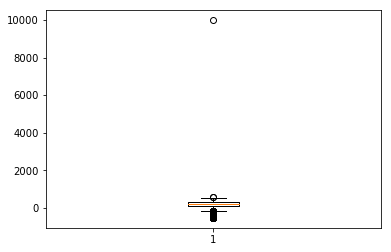

In [13]:
plt.boxplot(data_1975[data_1975.type=='TMAX'].value)
plt.show()

Okay, that outlier at the top is clearly an error in the data. Remove it:

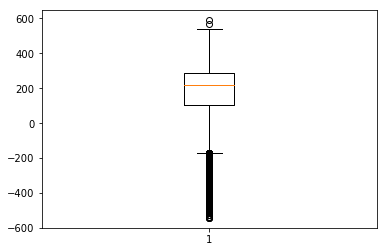

In [14]:
data_1975 = data_1975[data_1975.value < 2000]

plt.boxplot(data_1975[data_1975.type=='TMAX'].value)
plt.show()

That looks more reasonable. Values range from about -60 to +60C (units are [tenths of degrees centigrade](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt))

Next, we will calculate the difference between the measurement at the station and the measurement and the nearest neighbor, as well as the difference in latitude and population density:

In [15]:
data_1975['nn_value_diff'] = data_1975['value'] - data_1975['NN_value']
data_1975['nn_popdens_diff'] = data_1975['popdens1975'] - data_1975['NN_popdens1975']
data_1975['nn_lat_diff'] = data_1975['lat'] - data_1975['NN_lat']
data_1975.head()

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,NN_dist,NN_elev,nn_elev_diff,NN_value,NN_lat,NN_pop1975,NN_popdens1975,nn_value_diff,nn_popdens_diff,nn_lat_diff
0,CA007056600,1975-01-01,TMAX,-22,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,17227.408848,290.0,-77.0,-33,47.4833,0.0,0.0,11,0.0,-0.05
1,CA007056600,1975-01-01,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,17227.408848,290.0,-77.0,-83,47.4833,0.0,0.0,-28,0.0,-0.05
2,CA007056600,1975-01-02,TMAX,-61,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,17227.408848,290.0,-77.0,-39,47.4833,0.0,0.0,-22,0.0,-0.05
3,CA007056600,1975-01-02,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,17227.408848,290.0,-77.0,-122,47.4833,0.0,0.0,11,0.0,-0.05
4,CA007056600,1975-01-03,TMAX,-72,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,17227.408848,290.0,-77.0,-67,47.4833,0.0,0.0,-5,0.0,-0.05


Before we look at eleavation, quick sanity check: Plot temperature against latitude:

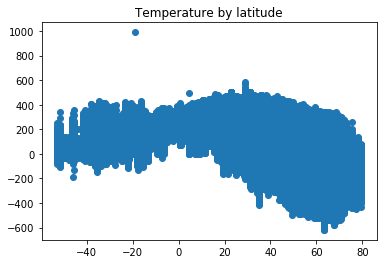

In [16]:
plt.scatter(data_1975['lat'], data_1975['value'])
plt.title('Temperature by latitude')
plt.show()

That's much more messy than I thought. Let's group them by distance from the equator (abs. lat) and make a grouped box plot (for 5 degree latitude intervals). This is probably not the most elegant way to do the grouping, but it works ¯\\\_(ツ)_/¯ 

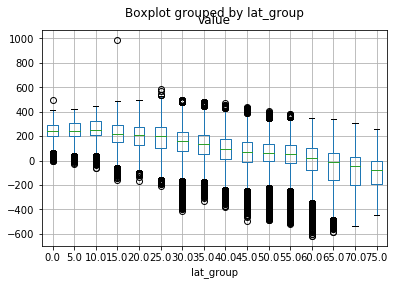

In [17]:
data_1975['lat_group'] = (abs(data_1975.lat) // 5) * 5 # put in 5 degree lat. groups

data_1975.boxplot(column = 'value', by= 'lat_group')

Let's try the same for altitude (remove that outlier at about 100 degrees first). Also, we need to take into account how far from the eqator a station is. So we'll 'double-group' them by latitude group **and** altitude group, then we should see a clear trend _within_ each group:

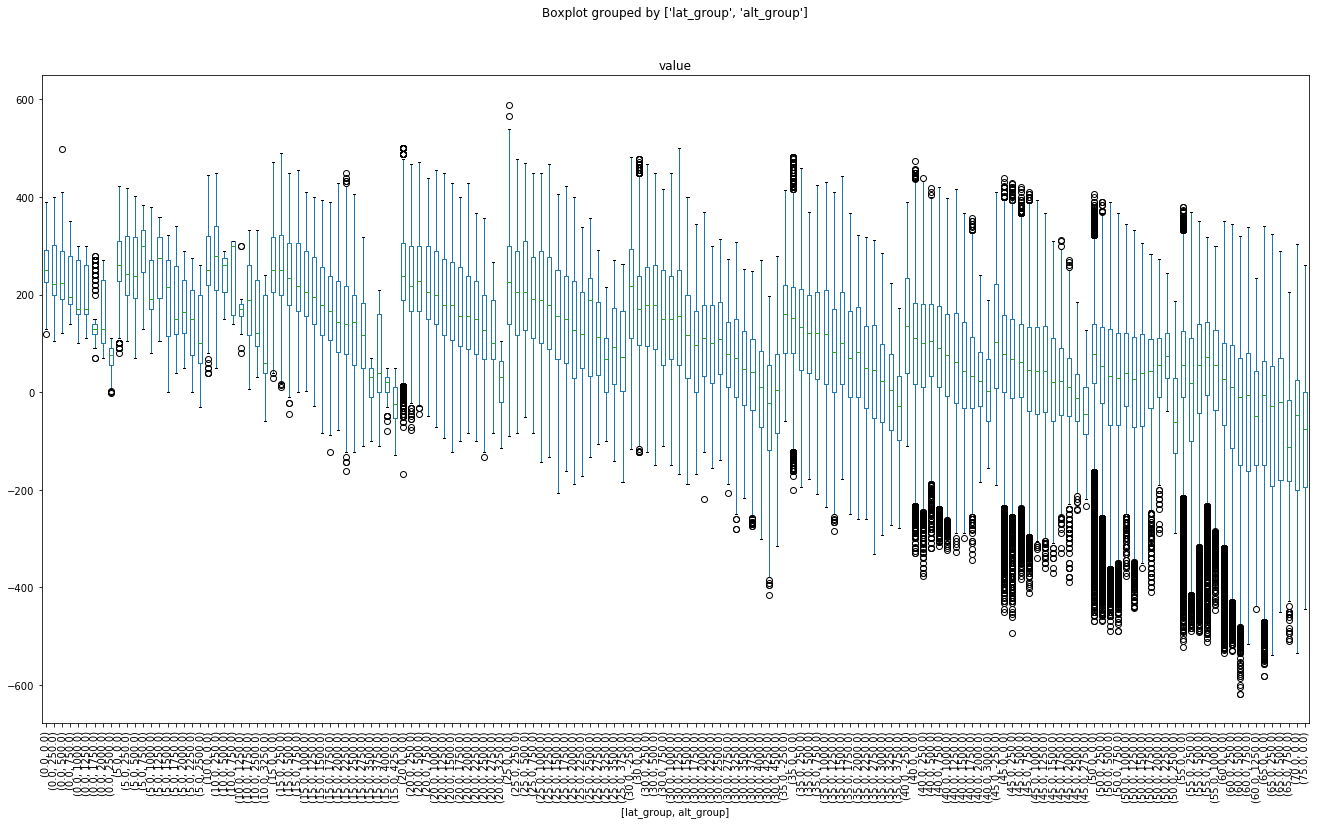

In [18]:
data_1975 = data_1975[data_1975.value < 800]

# put in 250m groups
data_1975['alt_group'] = (data_1975.elevation // 250) * 250

data_1975.boxplot(column = 'value', by= ['lat_group', 'alt_group'], grid=False, figsize=(22.0,12.0), rot=90)

Okay, so now we can plot the difference in temperature against the difference in elevation. We'll check whether the data is reasonably in line with the theoretical [dry adiabatic lapse rate](https://en.wikipedia.org/wiki/Lapse_rate#Dry_adiabatic_lapse_rate) of **9.8°C per km** altitude for each of the latitude groups:

In [19]:
# calculate regression line:
for group in sorted(data_1975.lat_group.unique()):
    slope, intercept, r_value, p_value, std_err = stats.linregress(data_1975[data_1975.lat_group == group].elevation,data_1975[data_1975.lat_group == group].value)
    # units of the output are in 10th of a degree per meter; multiply by 100 to get degrees per kilometer
    print(group,slope*100)

0.0 -5.540914007221801
5.0 -4.871986059383184
10.0 -4.512442276763722
15.0 -5.172922990968971
20.0 -3.8541364014935846
25.0 -4.075530181703173
30.0 -3.602284674735544
35.0 -4.119549274810256
40.0 -2.888110430280808
45.0 -3.0771489936469365
50.0 -5.799951576988495
55.0 -4.264202506167405
60.0 -8.162422637120994
65.0 -9.642773709073737
70.0 -156.1238874036552
75.0 88.52157604911342


Most of these look like they are more in the range of the [_moist_ adiabatic lapse rate](https://en.wikipedia.org/wiki/Lapse_rate#Moist_adiabatic_lapse_rate), which varies according to temperature, but is generally somewhere around 5°C per km. From about 60°, the lapse rates are closer to the dry adiabatic lapse rate, which makes sense (frost!), but beyond that, they are out of control. No idea what is going on there.

Anyway, this whole grouping exercise doesn't seem to get us anywhere (besides showing that the data generally makes sense, bare the occasional outlier, and is in line with the theory). Let's try a multivariate regression. We'll calculate the difference in latitude and elevation between each station and it's neighbor, as well as the distance between them. Then we will check how much of the difference in temperature for a given day this model can explain, and see if we can find a correlation between the residual and population density at the station.

Note that by using the difference between nearest neighbor stations, we can exclude the date from the model, since we compute these differences on the same day.

First, deal with the minimum daily temperatures (TMIN):

In [20]:
# independent variables:
X = data_1975[data_1975.type == 'TMIN'][['NN_dist','nn_elev_diff','nn_lat_diff']]

# dependent variable
Y = data_1975[data_1975.type == 'TMIN']['nn_value_diff']

regr_TMIN = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN.fit(X, Y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

Let's see how well that works by computing an [R<sup>2</sup> score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.score) for all observations:

In [26]:
regr_TMIN.score(X,Y)

0.11655627400939163

That's quite low. Let's try to include time in the equation (UHI only occurs in the summer, so including time should yield a better fit). First, let's try it with the day of the year. 

🔥 TODO: Also check the rest of the code for possible uses of apply/lambda instead of looping through the data frame.

In [37]:
data_1975['yday'] = data_1975['date'].apply(lambda x: x.timetuple().tm_yday)
data_1975.head(15)

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,NN_value,NN_lat,NN_pop1975,NN_popdens1975,nn_value_diff,nn_popdens_diff,nn_lat_diff,lat_group,alt_group,yday
0,CA007056600,1975-01-01,TMAX,-22,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,-33,47.4833,0.0,0.0,11,0.0,-0.05,45.0,0.0,1
1,CA007056600,1975-01-01,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,-83,47.4833,0.0,0.0,-28,0.0,-0.05,45.0,0.0,1
2,CA007056600,1975-01-02,TMAX,-61,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,-39,47.4833,0.0,0.0,-22,0.0,-0.05,45.0,0.0,2
3,CA007056600,1975-01-02,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,-122,47.4833,0.0,0.0,11,0.0,-0.05,45.0,0.0,2
4,CA007056600,1975-01-03,TMAX,-72,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,-67,47.4833,0.0,0.0,-5,0.0,-0.05,45.0,0.0,3
5,CA007056600,1975-01-03,TMIN,-222,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,-189,47.4833,0.0,0.0,-33,0.0,-0.05,45.0,0.0,3
6,CA007056600,1975-01-04,TMAX,-22,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,-11,47.4833,0.0,0.0,-11,0.0,-0.05,45.0,0.0,4
7,CA007056600,1975-01-04,TMIN,-89,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,-106,47.4833,0.0,0.0,17,0.0,-0.05,45.0,0.0,4
8,CA007056600,1975-01-05,TMAX,-78,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,-89,47.4833,0.0,0.0,11,0.0,-0.05,45.0,0.0,5
9,CA007056600,1975-01-05,TMIN,-233,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,-189,47.4833,0.0,0.0,-44,0.0,-0.05,45.0,0.0,5


In [40]:
data_1975.iloc[300]

station                    CA007056600
date               1975-06-01 00:00:00
type                              TMAX
value                              183
lat                            47.4333
lon                           -69.0333
elevation                          213
name                     RIVIERE BLEUE
country                             CA
mollX                     -5.42256e+06
mollY                      5.60209e+06
pop1975                              0
popdens1975                          0
NN                         CA007057145
NN_dist                        17227.4
NN_elev                            290
nn_elev_diff                       -77
NN_value                           189
NN_lat                         47.4833
NN_pop1975                           0
NN_popdens1975                       0
nn_value_diff                       -6
nn_popdens_diff                      0
nn_lat_diff                      -0.05
lat_group                           45
alt_group                

Build another regression model, but with day of the year as additional independent variable:

In [41]:
# independent variables:
X = data_1975[data_1975.type == 'TMIN'][['NN_dist','nn_elev_diff','nn_lat_diff','yday']]

# dependent variable
Y = data_1975[data_1975.type == 'TMIN']['nn_value_diff']

regr_TMIN_time = linear_model.LinearRegression(n_jobs = -1) # use all processors
regr_TMIN_time.fit(X, Y)
regr_TMIN_time.score(X, Y)

0.11655945862462502

Okay, (almost) no difference at all. This is a bit weird. Anyway, let's take a look at the residuals and plot them against difference in population density. We need to calculate the residuals first:

In [42]:
data_1975['predicted_diff'] = regr_TMIN_time.predict(data_1975[['NN_dist','nn_elev_diff','nn_lat_diff','yday']])
data_1975.head()

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,NN_lat,NN_pop1975,NN_popdens1975,nn_value_diff,nn_popdens_diff,nn_lat_diff,lat_group,alt_group,yday,predicted_diff
0,CA007056600,1975-01-01,TMAX,-22,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,47.4833,0.0,0.0,11,0.0,-0.05,45.0,0.0,1,2.707864
1,CA007056600,1975-01-01,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,47.4833,0.0,0.0,-28,0.0,-0.05,45.0,0.0,1,2.707864
2,CA007056600,1975-01-02,TMAX,-61,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,47.4833,0.0,0.0,-22,0.0,-0.05,45.0,0.0,2,2.707302
3,CA007056600,1975-01-02,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,47.4833,0.0,0.0,11,0.0,-0.05,45.0,0.0,2,2.707302
4,CA007056600,1975-01-03,TMAX,-72,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,47.4833,0.0,0.0,-5,0.0,-0.05,45.0,0.0,3,2.706741


In [43]:
data_1975['residual'] = data_1975['nn_value_diff'] - data_1975['predicted_diff']
data_1975.head()

,station,date,type,value,lat,lon,elevation,name,country,mollX,...,NN_pop1975,NN_popdens1975,nn_value_diff,nn_popdens_diff,nn_lat_diff,lat_group,alt_group,yday,predicted_diff,residual
0,CA007056600,1975-01-01,TMAX,-22,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,0.0,0.0,11,0.0,-0.05,45.0,0.0,1,2.707864,8.292136
1,CA007056600,1975-01-01,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,0.0,0.0,-28,0.0,-0.05,45.0,0.0,1,2.707864,-30.707864
2,CA007056600,1975-01-02,TMAX,-61,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,0.0,0.0,-22,0.0,-0.05,45.0,0.0,2,2.707302,-24.707302
3,CA007056600,1975-01-02,TMIN,-111,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,0.0,0.0,11,0.0,-0.05,45.0,0.0,2,2.707302,8.292698
4,CA007056600,1975-01-03,TMAX,-72,47.4333,-69.0333,213.0,RIVIERE BLEUE,CA,-5.422564e+06,...,0.0,0.0,-5,0.0,-0.05,45.0,0.0,3,2.706741,-7.706741


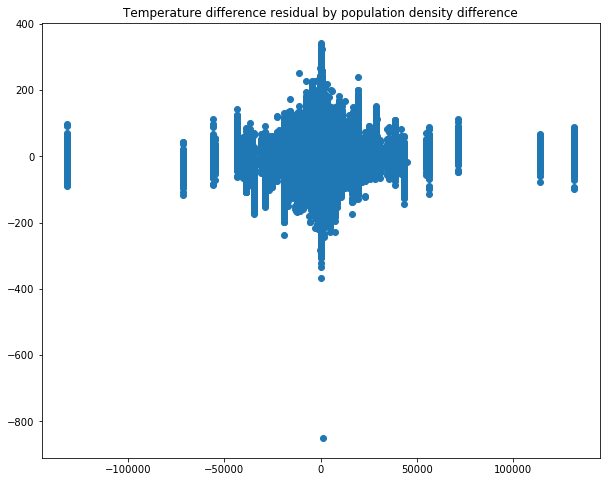

In [47]:
plt.scatter(data_1975[data_1975['residual'] > - 1000]['nn_popdens_diff'], # there's one weird outlier in there
            data_1975[data_1975['residual'] > - 1000]['residual'])
plt.title('Temperature difference residual by population density difference')
plt.show()

Hm, no clear trend to see here ☹️